# MUSIC for Direction of Arrival

This notebook is a demo of MUSIC for Direction of Arrival

# Introduction and mathematical background

MUSIC for Direction of Arrival is an algorithm to detect the direction (angle) of $D$ sources using their received signals on $M$ microphones. Assuming the channels are additive white Gaussian noise channels and the signals are narrowband, we have the received signal at microphone $m$, which has position $(x_m, y_m)$ on the $\mathbb{R}^2$ plane, with $\theta_k$ being the angle of source $k$, $x^{(m)}(t)$:

$$x^{(m)}(t)=\sum_{k=1}^D S_k(t)e^{-j \frac{2\pi}{\lambda} (x_m\cos(\theta_k)+y_m\sin(\theta_k))}+n_m(t)$$

Note that we assume that the source is far enough away for the angle to be the same for each microphone. Even though we consider a more general case than [[1]](#paper_1) with microphones that may not be aligned, we assume that they are relatively close compared to the sources, which are at a distance order(s) of magnitude higher than the distance between microphones. Thus, for one source, the angle to all microphones is approximately the same.

$n_m(t)$ is a white Gaussian process with variance $\sigma^2$, independent for each microphone, $\lambda$ is the wavelength and $S_k(t)$ is the wavefront signal, assumed to be narrowband.

Note that by writing $a_m(\theta_k)=e^{-j \frac{2\pi}{\lambda} (x_m\cos(\theta_k)+y_m\sin(\theta_k))}$, we have

$$x^{(m)}(t)=\sum_{k=1}^D a_m(\theta_k)S_k(t)+n_m(t)$$

We will use this below to rewrite this as a matrix equation.

<font color='#d197ab'>
    
## Proof of the angle distance:
    
todo!!!!</font>

In vector form, this can also be written as

$$X=AS+N$$ (todo add dependency on t?)

where

$$X=\begin{pmatrix} x^{(1)}(t) \\ x^{(2)}(t) \\ ... \\ x^{(M)}(t)\end{pmatrix}, \ \ S = \begin{pmatrix} S_1(t) \\ S_2(t) \\ ... \\ S_D(t)\end{pmatrix}, \ \ N = \begin{pmatrix} n_1(t) \\ n_2(t) \\ ... \\ n_M(t)\end{pmatrix}$$


and $A$ is an $M\times D$ matrix such that the entry at the $m$'th row and $k$'th column is $A_{m,k}=e^{-j \frac{2\pi}{\lambda} (x_m\cos(\theta_k)+y_m\sin(\theta_k))}$. That is, using our earlier notation, $A_{m,k}=a_m(\theta_k)$.

Using calculations seen and done in class, we have the auto-correlation matrix $R_X=AR_SA^H+\sigma ^2 I$ (replaced by the empirical estimation in practice) and its eigenvalues and eigenvectors $v_i$ and $\lambda_i$ for $1\leq i \leq M$, with the eigenvalues sorted in decreasing order ($\lambda_i\geq \lambda_{i+1}$).

The first $D$ eigenvalues and eigenvectors correspond to the signal supspace where as the remaining eigenvalues correspond to the noise subspace and should be $\lambda_i=\sigma^2$ for $D<i\leq M$.

Using the fact that for such $i$, $R_X v_i= \sigma^2v_i$ and subtituting our expression for $R_X$ into this, we find that $A^Hv_i=0$, from which we can construct the $M\times (M-D)$ noise matrix $E_n$ with the noise eigenvectors and therefore the spatial spectrum $P(\theta)$ as follows:

$$E_n= \begin{pmatrix} v_{D+1} & ... & v_{M}\end{pmatrix}$$

$$P(\theta)=\frac{1}{||E_n^Ha(\theta)||^2}$$

where $a(\theta)=\begin{pmatrix} a_1(\theta) \\ ... \\ a_M(\theta)\end{pmatrix}$.

Then, the maximum values of $P(\theta)$ (the peaks) should correspond to the angles $\theta_1$ to $\theta_D$, i.e. the angles of the $D$ sources.

Note that apart from the additional proof, all of this was seen in class and/or in [[1]](#paper_1) and is thus not described in full detail (as it is something we had to understand, but not actually do).

# Methods

In this part, we implement the workflow of MUSIC for DOA described above and test it on real and simulated data. The results are discussed below (todo). 

## Test on simulated data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks

import sys
sys.path.append("src")

from music import *
from simulated_signal import *

In [2]:
# Constants
thetas = np.array([0.5, 1]) # in radians (should be in [0, pi/2])
n_sources = len(thetas)
w0 = np.pi / 5
n_mics = 20
mic_distance = 1
noise_var = 3
fs = 2000

mic_coords = np.array([(0, mic_distance * i) for i in range(n_mics)]).T
main_frequency = (fs * w0) / (2 * np.pi)
wavelength = SOUND_SPEED / main_frequency

### Craft the signal

As mentioned in our first section, we have 2 ways of crafting a simulated signal:

1. With a simulated function that we sample
2. Directly with the matrices containing the samples of our function

We start with the simulated function:

Note that here, we suppose that $x_m=0$ for all $m$ and $y_m=d\cdot (m-1)$, where $d$ is the distance between mics. This is how `received_signal` is implemented. That is, our earlier equation

$$x^{(m)}(t)=\sum_{k=1}^D S_k(t)e^{-j \frac{2\pi}{\lambda} (x_m\cos(\theta_k)+y_m\sin(\theta_k))}+n_m(t)$$

becomes

$$x^{(m)}(t)=\sum_{k=1}^D S_k(t)e^{-j \frac{2\pi}{\lambda} d (m-1) \sin(\theta_k)}+n_m(t)$$

In [3]:
narrowband_signals = [narrowband_signal(k, w0) for k in range(n_sources)]
received_signals = [received_signal(thetas, narrowband_signals, 
                                    mic_index=m+1, 
                                    main_frequency=main_frequency,
                                    mic_distance=mic_distance, 
                                    noise_var=noise_var) for m in range(n_mics)]

n_samples = 100

sampled_received = np.zeros((len(received_signals), n_samples), dtype=np.csingle)

for i, received in enumerate(received_signals):
    for j in range(n_samples):
        sampled_received[i, j] = received(j / fs)

sampled_received.shape

(20, 100)

Directly with the samples in matrix form:

Just like before, $x_m=0$ and $y_m=d\cdot(m-1)$, so $A$ becomes a Vandermonde Matrix, namely:

$$A_{m,k}=e^{-j \frac{2\pi}{\lambda} d(m-1)\sin(\theta_k)}$$
so with $\varphi_k=\frac{2\pi}{\lambda}d\sin(\theta_k)$

$$A = \begin{pmatrix} 1 & 1 & ... & 1\\ e^{-j \frac{2\pi}{\lambda} d\sin(\theta_1)}&e^{-j \frac{2\pi}{\lambda} d\sin(\theta_2)}&...&e^{-j \frac{2\pi}{\lambda} d\sin(\theta_D)} \\ ... \\  e^{-j \frac{2\pi}{\lambda} d(M-1)\sin(\theta_1)}&e^{-j \frac{2\pi}{\lambda} d(M-1)\sin(\theta_2)}&...&e^{-j \frac{2\pi}{\lambda} d(M-1)\sin(\theta_D)}\end{pmatrix}= \begin{pmatrix} 1 & 1 & ... & 1\\ e^{-j\varphi_1}&e^{-j \varphi_2}&...&e^{-j \varphi_D} \\ ... \\  e^{-j (M-1)\varphi_1}&e^{-j (M-1)\varphi_2}&...&e^{-j (M-1)\varphi_D}\end{pmatrix}$$


In [4]:
phis = np.array([np.exp(-2j * np.pi * mic_distance * np.sin(theta) / wavelength) for theta in thetas])
A = np.vander(phis, n_mics, increasing=True).T
S = np.random.normal(0, 1, (n_sources, n_samples))
noise_matrix = np.random.normal(0, noise_var, (n_mics, n_samples, 2)).view(np.complex128).reshape((n_mics, n_samples))

sampled_received = (A @ S) + noise_matrix 

Note that both implementations are correct and give the same result as long as $S$ is represented by the same function as `narrowband_signal` and sampled the same way. Here, in the first example, $S_k(t)=f(k, t)e^{-j \cdot \omega_0 \cdot t}$ where $f(k, t)$ is deterministic function of $k$ and $t$ whereas the samples in the second case are realisations or a Gaussian process with mean $0$ and variance $1$, so they are not actually the same.

### Music implementation

Samples shape: (20, 100)
Covariance shape: (20, 20)


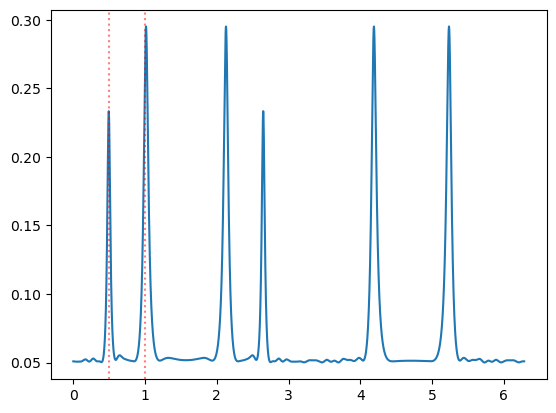

In [7]:
spectrum = music(sampled_received, n_sources, mic_coords, main_frequency)

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in thetas:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

Extract the frequencies from the peaks. Note that our method only works for theta in $\left[0, \frac{\pi}{2} \right]$ because of the symmetry of the complex exponential and sinus function.

In [6]:
estimated_thetas = extract_frequencies(spectrum, n_sources, [0, np.pi / 2])
print(estimated_thetas)

[0.49448668 1.01347779]
